# Importing required libraries

In [8]:
!pip install IPython

You should consider upgrading via the 'C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from IPython.display import HTML

# Storing data into tensorflow dataset

In [10]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=24,
)

Found 16011 files belonging to 10 classes.


In [12]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [13]:
len(dataset)

1001

In [14]:
1001*16

16016

In [15]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[2 6 6 3 6 6 0 0 4 7 2 4 0 7 1 5]


# Visualization of an image from the tf dataset

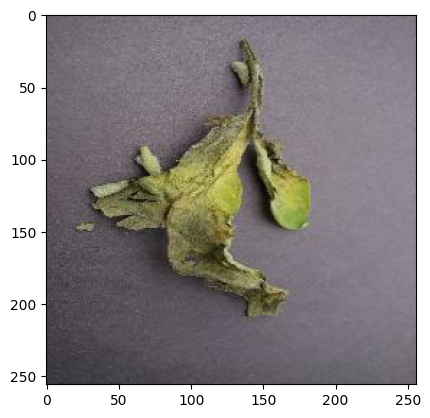

In [16]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [17]:
EPOCHS = 50 #model will see the same image 50 times

# Train test split

**80%** training set <br>
**10%** validation set <br>
**10%** test set

In [18]:
def get_partitioned_datasets(dataset, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    if shuffle:
        dataset=dataset.shuffle(shuffle_size, seed = 10)
        
    dataset_len = len(dataset)      

    train_len = int(train_split*dataset_len)
    train_dataset = dataset.take(train_len)
    dataset = dataset.skip(train_len)

    val_len = int(dataset_len*val_split)
    val_dataset = dataset.take(val_len)
    dataset = dataset.skip(val_len)

    test_len = dataset_len - train_len - val_len
    test_dataset = dataset.take(test_len)
    
    
    return train_dataset, val_dataset, test_dataset

In [19]:
train_dataset, val_dataset, test_dataset = get_partitioned_datasets(dataset)

In [20]:
len(train_dataset)

800

In [21]:
len(val_dataset)

100

In [22]:
len(test_dataset)

101

prefetch() is used when the GPU is training one batch, at the same time the CPU will train another batch so it will take less time

In [23]:
train_dataset  = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset  = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset  = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation

In [24]:
ONE_IMAGE_SIZE = 256

In [25]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2)
])

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'RandomBrightness'

In [20]:
CHANNELS = 3
input_shape = (BATCH_SIZE, ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# I have deleted two pairs of (2nd Conv2D and MaxPooling2D)

model.build(input_shape=input_shape)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=8
)

Epoch 1/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - accuracy: 0.4650 - loss: 1.5188 - val_accuracy: 0.8219 - val_loss: 0.5290
Epoch 2/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.8008 - loss: 0.5866 - val_accuracy: 0.8631 - val_loss: 0.3882
Epoch 3/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.8598 - loss: 0.3917 - val_accuracy: 0.8819 - val_loss: 0.3479
Epoch 4/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.9027 - loss: 0.2785 - val_accuracy: 0.9319 - val_loss: 0.1972
Epoch 5/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.9259 - loss: 0.2113 - val_accuracy: 0.9513 - val_loss: 0.1380
Epoch 6/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.9513 - loss: 0.1355 - val_accuracy: 0.9581 - val_loss: 0.1177
Epoch 7/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.9621 - loss: 0.1169 - val_accuracy: 0.8981 - val_loss: 0.3253
Epoch 8/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.9613 - loss: 0.1115 - val_accu

In [24]:
model.evaluate(test_dataset)

101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9749 - loss: 0.0794


[0.09201940149068832, 0.9702970385551453]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 8, 'steps': 800}

The first image:
The first image's actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
The predicted label: Tomato_Bacterial_spot


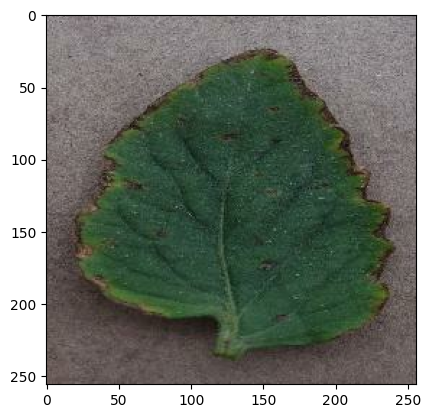

In [36]:
for image_batch, label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print("The first image:")
    plt.imshow(first_image)
    print("The first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("The predicted label:", class_names[np.argmax(batch_prediction[0])])

In [3]:
model.save('my_model.h5')

NameError: name 'model' is not defined

In [26]:
model = models.load_model('image_Classifier.keras')

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


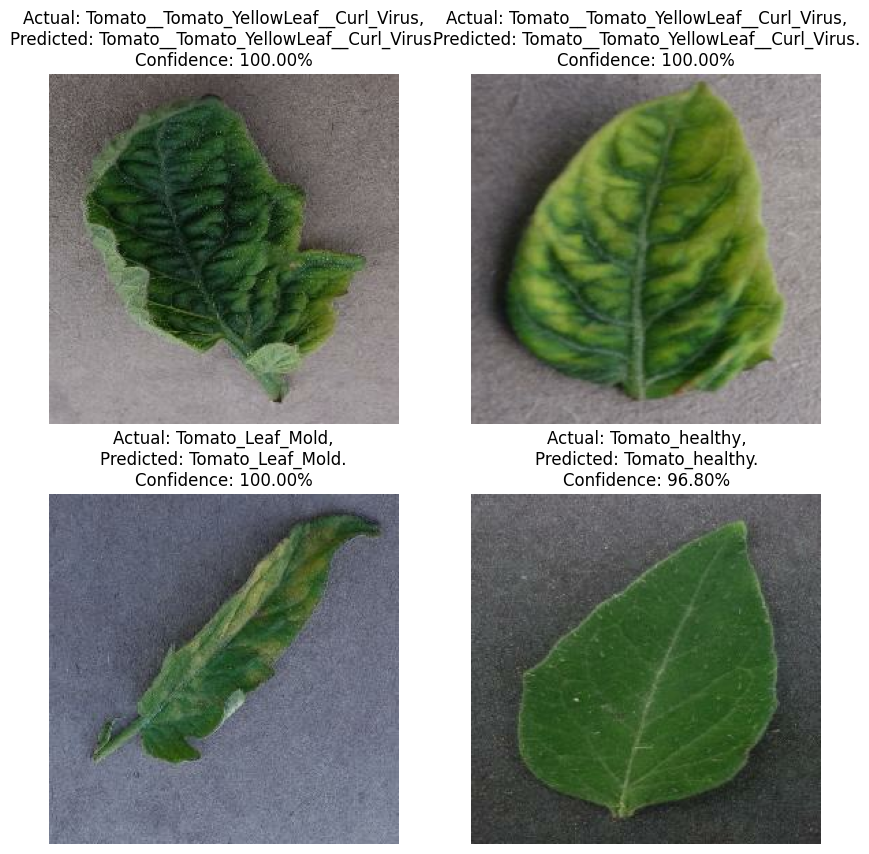

In [28]:
plt.figure(figsize=(10, 10))  

# Iterate over one batch of images and labels from the test dataset
for images, labels in test_dataset.take(1):
    for i in range(4):  # Change the range to 4 to show only 4 images
        ax = plt.subplot(2, 2, i + 1)  # Adjust the grid to 2x2
        plt.imshow(images[i].numpy().astype("uint8"))

        # Assuming `predict` is a custom function that returns the predicted class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}.\nConfidence: {confidence:.2f}%")
        plt.axis("off")

plt.show()  # Ensure the plot is displayed